# Approach 3: XLM-RoBERTa with Weighted Loss

**Strategy:** Single XLM-RoBERTa model with class-weighted cross-entropy loss and cosine annealing scheduler.


In [1]:
# Setup
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from tqdm.auto import tqdm

# Seeds
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

E0000 00:00:1766298910.990810      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766298911.051990      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Device: cuda
GPU: Tesla T4


In [2]:
# Load data
def load_data(base_path, split='train'):
    path = f"{base_path}/{split}"
    with open(f"{path}/sents.txt", 'r', encoding='utf-8') as f:
        sentences = [line.strip() for line in f]
    with open(f"{path}/sentiments.txt", 'r', encoding='utf-8') as f:
        sentiments = [int(line.strip()) for line in f]
    return sentences, sentiments

DATA_PATH = "/kaggle/input/nlpnlp/data"
# DATA_PATH = "data"  # For local

train_sents, train_labels = load_data(DATA_PATH, 'train')
dev_sents, dev_labels = load_data(DATA_PATH, 'dev')
test_sents, test_labels = load_data(DATA_PATH, 'test')

sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
print(f"Train: {len(train_sents)} | Dev: {len(dev_sents)} | Test: {len(test_sents)}")

# Distribution
unique, counts = np.unique(train_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"{sentiment_labels[u]}: {c} ({c/len(train_labels)*100:.2f}%)")

Train: 11426 | Dev: 1583 | Test: 3166
Negative: 5325 (46.60%)
Neutral: 458 (4.01%)
Positive: 5643 (49.39%)


In [3]:
# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Training functions
def train_epoch(model, loader, optimizer, scheduler, loss_fn, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / len(loader), correct / total

def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

print("Dataset and functions ready")

Dataset and functions ready


## Model Setup

In [4]:
# Tokenizer and datasets
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

BATCH_SIZE = 16
train_dataset = SentimentDataset(train_sents, train_labels, tokenizer)
dev_dataset = SentimentDataset(dev_sents, dev_labels, tokenizer)
test_dataset = SentimentDataset(test_sents, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Model
model = XLMRobertaForSequenceClassification.from_pretrained(
    'xlm-roberta-base',
    num_labels=3
).to(device)

# Class weights for imbalanced data
class_counts = np.bincount(train_labels)
class_weights = len(train_labels) / (len(class_counts) * class_counts)
class_weights = torch.FloatTensor(class_weights).to(device)

print("Class weights:")
for i, w in enumerate(class_weights):
    print(f"  {sentiment_labels[i]}: {w:.3f}")

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=2, eta_min=1e-7)

print("\nModel ready")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights:
  Negative: 0.715
  Neutral: 8.316
  Positive: 0.675

Model ready


## Training

In [5]:
EPOCHS = 10
PATIENCE = 3

best_f1 = 0
best_neutral_f1 = 0
no_improve = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, loss_fn, device)
    dev_labels_true, dev_preds = evaluate(model, dev_loader, device)
    
    _, _, dev_f1, _ = precision_recall_fscore_support(dev_labels_true, dev_preds, average='weighted')
    _, _, dev_f1_per_class, _ = precision_recall_fscore_support(dev_labels_true, dev_preds, average=None)
    neutral_f1 = dev_f1_per_class[1]
    
    print(f"Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}%")
    print(f"Dev F1: {dev_f1*100:.2f}% | Neutral: {neutral_f1*100:.2f}%")
    
    if dev_f1 > best_f1:
        best_f1 = dev_f1
        best_neutral_f1 = neutral_f1
        torch.save(model.state_dict(), 'xlm_roberta_best.pt')
        print(f"Saved best model")
        no_improve = 0
    else:
        no_improve += 1
    
    if no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch + 1}")
        break

model.load_state_dict(torch.load('xlm_roberta_best.pt'))
print(f"\nBest dev F1: {best_f1*100:.2f}% | Neutral: {best_neutral_f1*100:.2f}%")


Epoch 1/10


Training:   0%|          | 0/715 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/99 [00:00<?, ?it/s]

Loss: 0.6661 | Acc: 87.80%
Dev F1: 93.59% | Neutral: 60.61%
Saved best model

Epoch 2/10


Training:   0%|          | 0/715 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/99 [00:00<?, ?it/s]

Loss: 0.5320 | Acc: 93.18%
Dev F1: 93.83% | Neutral: 58.39%
Saved best model

Epoch 3/10


Training:   0%|          | 0/715 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/99 [00:00<?, ?it/s]

Loss: 0.4673 | Acc: 93.95%
Dev F1: 94.08% | Neutral: 63.70%
Saved best model

Epoch 4/10


Training:   0%|          | 0/715 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/99 [00:00<?, ?it/s]

Loss: 0.3637 | Acc: 95.75%
Dev F1: 94.48% | Neutral: 62.32%
Saved best model

Epoch 5/10


Training:   0%|          | 0/715 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/99 [00:00<?, ?it/s]

Loss: 0.3544 | Acc: 95.79%
Dev F1: 93.82% | Neutral: 57.39%

Epoch 6/10


Training:   0%|          | 0/715 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/99 [00:00<?, ?it/s]

Loss: 0.3871 | Acc: 95.97%
Dev F1: 94.43% | Neutral: 62.81%

Epoch 7/10


Training:   0%|          | 0/715 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/99 [00:00<?, ?it/s]

Loss: 0.2321 | Acc: 97.43%
Dev F1: 94.62% | Neutral: 65.22%
Saved best model

Epoch 8/10


Training:   0%|          | 0/715 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/99 [00:00<?, ?it/s]

Loss: 0.1536 | Acc: 98.24%
Dev F1: 94.46% | Neutral: 64.79%

Epoch 9/10


Training:   0%|          | 0/715 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/99 [00:00<?, ?it/s]

Loss: 0.1497 | Acc: 98.07%
Dev F1: 93.84% | Neutral: 59.09%

Epoch 10/10


Training:   0%|          | 0/715 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/99 [00:00<?, ?it/s]

Loss: 0.2690 | Acc: 96.86%
Dev F1: 93.78% | Neutral: 59.84%
Early stopping at epoch 10

Best dev F1: 94.62% | Neutral: 65.22%


## Test Results

In [6]:
test_labels_true, test_preds = evaluate(model, test_loader, device)

precision, recall, f1, _ = precision_recall_fscore_support(test_labels_true, test_preds, average='weighted')
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(test_labels_true, test_preds, average=None)

classes = ['Negative', 'Neutral', 'Positive']
print(f"{'Class':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 60)
for i, cls in enumerate(classes):
    print(f"{cls:<12} {precision_per_class[i]*100:>6.2f}% {recall_per_class[i]*100:>6.2f}% {f1_per_class[i]*100:>6.2f}%")
print("-" * 60)
print(f"{'Overall':<12} {precision*100:>6.2f}% {recall*100:>6.2f}% {f1*100:>6.2f}%")

Evaluating:   0%|          | 0/198 [00:00<?, ?it/s]

Class        Precision    Recall       F1-Score    
------------------------------------------------------------
Negative      94.37%  96.38%  95.37%
Neutral       69.67%  50.90%  58.82%
Positive      94.89%  95.79%  95.34%
------------------------------------------------------------
Overall       93.33%  93.68%  93.42%


## Comparison

In [7]:
baseline = {'precision': 87.71, 'recall': 88.66, 'f1': 87.94, 'neutral_f1': 33.99}
phobert = {'precision': 93.01, 'recall': 92.99, 'f1': 93.00, 'neutral_f1': 59.52}

print("Comparison:")
print(f"{'Approach':<20} {'Overall F1':<12} {'Neutral F1':<12}")
print("-" * 50)
print(f"{'Baseline':<20} {baseline['f1']:>6.2f}% {baseline['neutral_f1']:>11.2f}%")
print(f"{'phoBERT':<20} {phobert['f1']:>6.2f}% {phobert['neutral_f1']:>11.2f}%")
print(f"{'XLM-RoBERTa':<20} {f1*100:>6.2f}% {f1_per_class[1]*100:>11.2f}%")
print("-" * 50)
print(f"\nvs Baseline: +{f1*100 - baseline['f1']:.2f}% overall, +{f1_per_class[1]*100 - baseline['neutral_f1']:.2f}% neutral")
print(f"vs phoBERT:  {f1*100 - phobert['f1']:+.2f}% overall, {f1_per_class[1]*100 - phobert['neutral_f1']:+.2f}% neutral")

Comparison:
Approach             Overall F1   Neutral F1  
--------------------------------------------------
Baseline              87.94%       33.99%
phoBERT               93.00%       59.52%
XLM-RoBERTa           93.42%       58.82%
--------------------------------------------------

vs Baseline: +5.48% overall, +24.83% neutral
vs phoBERT:  +0.42% overall, -0.70% neutral


## Visualizations

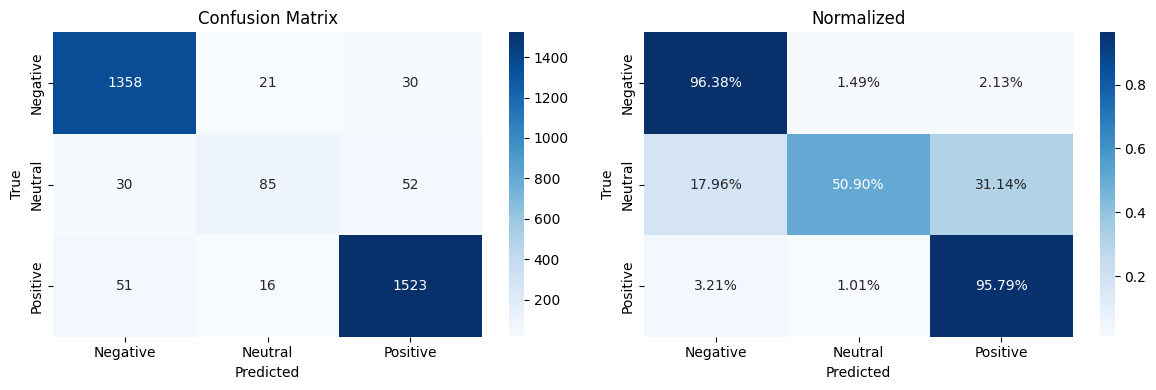

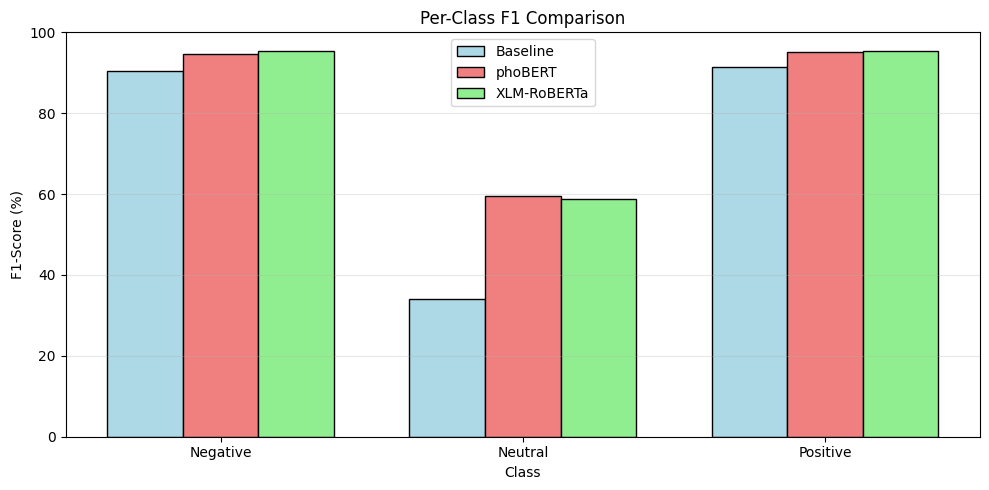

In [8]:
# Confusion matrix
cm = confusion_matrix(test_labels_true, test_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=classes, yticklabels=classes)
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1], xticklabels=classes, yticklabels=classes)
axes[1].set_title('Normalized')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# Per-class comparison
baseline_f1_per_class = [90.52, 33.99, 91.32]
phobert_f1_per_class = [94.68, 59.52, 95.02]

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(classes))
width = 0.25

ax.bar(x - width, baseline_f1_per_class, width, label='Baseline', color='lightblue', edgecolor='black')
ax.bar(x, phobert_f1_per_class, width, label='phoBERT', color='lightcoral', edgecolor='black')
ax.bar(x + width, f1_per_class*100, width, label='XLM-RoBERTa', color='lightgreen', edgecolor='black')

ax.set_xlabel('Class')
ax.set_ylabel('F1-Score (%)')
ax.set_title('Per-Class F1 Comparison')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 100])

plt.tight_layout()
plt.show()

## Save Results

In [9]:
import json

# Predictions
results_df = pd.DataFrame({
    'sentence': test_sents,
    'true_label': [sentiment_labels[l] for l in test_labels_true],
    'predicted_label': [sentiment_labels[l] for l in test_preds],
    'correct': test_labels_true == test_preds
})
results_df.to_csv('approach3_predictions.csv', index=False, encoding='utf-8-sig')

# Metrics
metrics = {
    'approach': 'XLM-RoBERTa with Weighted Loss',
    'overall': {
        'precision': float(precision * 100),
        'recall': float(recall * 100),
        'f1': float(f1 * 100)
    },
    'per_class': {
        'negative': {'precision': float(precision_per_class[0] * 100), 'recall': float(recall_per_class[0] * 100), 'f1': float(f1_per_class[0] * 100)},
        'neutral': {'precision': float(precision_per_class[1] * 100), 'recall': float(recall_per_class[1] * 100), 'f1': float(f1_per_class[1] * 100)},
        'positive': {'precision': float(precision_per_class[2] * 100), 'recall': float(recall_per_class[2] * 100), 'f1': float(f1_per_class[2] * 100)}
    },
    'improvements': {
        'vs_baseline': {'overall_f1': float(f1 * 100 - baseline['f1']), 'neutral_f1': float(f1_per_class[1] * 100 - baseline['neutral_f1'])},
        'vs_phobert': {'overall_f1': float(f1 * 100 - phobert['f1']), 'neutral_f1': float(f1_per_class[1] * 100 - phobert['neutral_f1'])}
    }
}

with open('approach3_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

print(f"Results saved")
print(f"\nFinal: {f1*100:.2f}% Overall | {f1_per_class[1]*100:.2f}% Neutral")

Results saved

Final: 93.42% Overall | 58.82% Neutral
